# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

### Признаки
RowNumber — индекс строки в данных
CustomerId — уникальный идентификатор клиента
Surname — фамилия
CreditScore — кредитный рейтинг
Geography — страна проживания
Gender — пол
Age — возраст
Tenure — сколько лет человек является клиентом банка
Balance — баланс на счёте
NumOfProducts — количество продуктов банка, используемых клиентом
HasCrCard — наличие кредитной карты
IsActiveMember — активность клиента
EstimatedSalary — предполагаемая зарплата
### Целевой признак
Exited — факт ухода клиента


## План работы над проектом
1. Изучить данные. Разбить данные на тренировочную, валидационную и тестовую выборку.
2. Исследовать задачу. Проверить модели на данных без изменений.
3. Скоректировать балланс класса. Изменить вес класса, урезать 0 или добавить 1.
4. Получить лучшую модель.
5. Провести финальный тест.
6. Написать вывод.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv('/datasets/Churn.csv')#прочитаем датасет
print(data.shape)#выведим количество строк
display(data.head())#выведим первые 5 строк

(10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
data.info()#изучим тип переменных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
data.columns = data.columns.str.lower()#приведем названия столбцов к нижнему регистру

In [5]:
data.isnull().sum()#проверим пропуски в столбцах

rownumber            0
customerid           0
surname              0
creditscore          0
geography            0
gender               0
age                  0
tenure             909
balance              0
numofproducts        0
hascrcard            0
isactivemember       0
estimatedsalary      0
exited               0
dtype: int64

___Комментарии:___ Много пропусков в столбце "Tenure", сколько лет является человек клиентом банка, так как мы не знаем этого факта, заполним пропуски 0.

In [6]:
data['tenure'] = data['tenure'].fillna(0)#заменим значения пропусков в столбце нулем

In [7]:
unique, counts = np.unique(data.exited, return_counts = True)#проверим целевой признак на сбалансированность
unique, counts

(array([0, 1]), array([7963, 2037]))

<AxesSubplot:>

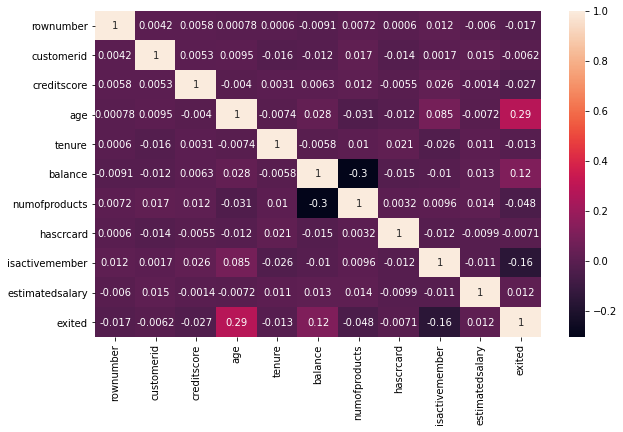

In [8]:
# Матрица корреляции
correlation_matrix = data.corr()

# Выводим признаки на тепловую карту
plt.figure(figsize= (10, 6))
sns.heatmap(correlation_matrix, annot = True)

___Комментарии:___ Наиболее зависимые признаки от целевого признака факта ухода из банка, это признак возраста и баланса на счете. Менее зависимые категориальные признаки, по которым мы не можем судить корреляцию. Таким образом, мы удалим столбцы малозначимые визуально, индекс строки, уникальный идентификатор клиента, фамилия. Для дальнейших действий они не имеют значение для получения прогнозируемой цели ухода из банка клиента.

In [9]:
data = data.drop(columns = ['rownumber', 'customerid', 'surname'],axis = 1)#удалим из датафрейма столбцы малозначимые

____Комментарии:____ Много клиентов-10000. Много категориальных признаков - фамилия, индентификатор клиента, страна проживания, пол, наличие кредитной карты, активность клиента, факт ухода клиента. Клиенты которые не ушли из банка почти 8000 против 2000, которые покинули банковскую систему. Целевой признак категориальный. Значит будем пробывать метрики классификации, так как задача категориальная, факт ухода да-1, нет-0 в целевом признаке "Exited".

## Исследование задачи

#### Масштабирование признаков.

In [10]:
data_ohe = pd.get_dummies(data, drop_first=True)#преобразуем датафрейм техникой OHE
print(data_ohe.columns)#выведим на экран названия столбцов
features = data_ohe.drop(['exited'], axis=1)#выделим признаки
target = data_ohe['exited']#выделим целевой признак

Index(['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited', 'geography_Germany',
       'geography_Spain', 'gender_Male'],
      dtype='object')


In [11]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, random_state=54321, stratify=target)
#отделяем 40% данных для валидационной выборки
features_train, features_test, target_train, target_test = train_test_split(
   features_train, target_train, test_size=0.2, random_state=54321, stratify=target_train)#отделим 20% для тестовой выборки

In [12]:
numeric = ['creditscore', 'age', 'tenure', 'balance',
       'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary']#выделим список всех численных признаков
pd.options.mode.chained_assignment = None
scaler = StandardScaler()#преобразуем масштаб методом стандартизации
scaler.fit(features_valid[numeric])#настроим объект структуры на валидационных данных
features_valid[numeric] = scaler.transform(features_valid[numeric])#преобразуем данные функцией
features_valid.shape

(4000, 11)

In [13]:
scaler.fit(features_train[numeric])#стандартизуем данные на обучающей выборке
features_train[numeric] = scaler.transform(features_train[numeric])#преобразуем данные функцией
features_train.shape

(4800, 11)

In [14]:
scaler.fit(features_test[numeric])#стандартизуем данные на тестовой выборке
features_test[numeric] = scaler.transform(features_test[numeric])#преобразуем данные тестовой выборки
features_test.shape

(1200, 11)

____Комментарии:___ У признаков был разный масштаб, поэтому мы из стандартизировали, чтобы машина не решила что какой-то признак важнее. Мы стандартизировали все выборки, для того чтобы потом проверить на тестовой выборке лучшую модель.

#### Accuracy для случайного леса

In [15]:
best_model=None
best_result=0
for est in range(1,50):
    model = RandomForestClassifier(random_state=54321, n_estimators=est)#создадим модель для случайного леса
    model.fit(features_train, target_train)#обучим модель
    result=model.score(features_valid, target_valid)#посчитаем качество модели
    if result>best_result:
        best_model = model#сохраним наилучшую модель
        best_result = result#сохраним наилучшее значение метрики accuracy

print("Accuracy наилучшей модели на валидационной выборке:", best_result)
predicted_valid = model.predict(features_valid)#предскажем модель
accuracy_valid = accuracy_score(target_valid, predicted_valid)#посчитаем качество модели
print("Accuracy предсказаний на валидационной выборке:", accuracy_valid)

Accuracy наилучшей модели на валидационной выборке: 0.86225
Accuracy предсказаний на валидационной выборке: 0.861


____Комментарии:____ Правильность ответов на валидационной выборке 86%, лучший результат получился на модели случайного леса.

#### Проверка адекватности модели

0    0.7963
1    0.2037
Name: exited, dtype: float64


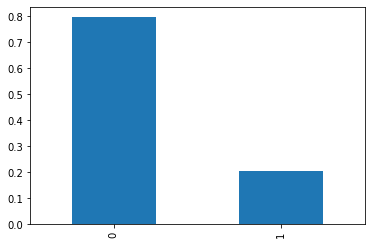

In [16]:
class_frequency = data_ohe['exited'].value_counts(normalize=True)#посчитаем относительную частоту уникальных значений
print(class_frequency)#выведим на экран частоту уникальных значений
class_frequency.plot(kind='bar');#построим диаграмму

___Комментарии:___ Чаще встречается класс 0 в целевом признаке, чем 1. 20% клиентов уходят из банка.

0    0.87175
1    0.12825
dtype: float64


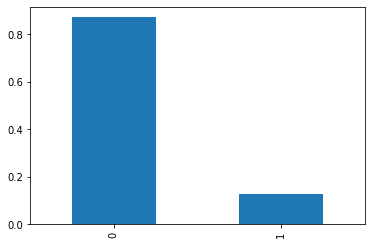

In [17]:
predicted_valid = pd.Series(model.predict(features_valid))
#чтобы функция value_counts() работала, мы преобразуем результаты к pd.Series
class_frequency = predicted_valid.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar');#построим диаграмму

____Комментарии:___ В результате предсказаний решающего дерева, частоты классов изменились, теперь уходят из банка 12% клиентов, а 87% остаются.

In [18]:
target_pred_constant = pd.Series(0, index=target.index)#создадим константную модель, для любого объекта прогнозирует 0
print(accuracy_score(target, target_pred_constant))

0.7963


____Комментарии:____ В итоге проверку на адекватность модель не прошла, 79% клиентов остались в банке судя по ответам, как и ранее.

## Борьба с дисбалансом

#### Матрица ошибок

In [19]:
print(confusion_matrix(target_valid, predicted_valid))#построим матрицу ошибок для случайного леса

[[3058  127]
 [ 429  386]]


___Комментарии:___ Истинно положительных ответов(TP) 386, истинно отрицательных ответов(TN) 3058, ложноположительных ответов(FP) 127, ложноотрицательных ответов (FN) 429. 127 клиентов по факту отстались в банковской системе, а модель предсказала что они ушли из банковской системы. 429 клиентов ушли из банка, а модель предсказала что они остались в банковской системе.

#### F-1 метрика

In [20]:
recall = recall_score(target_valid, predicted_valid)#найдем полноту на вадлидационной выборке
precision = precision_score(target_valid, predicted_valid)#найдем точность на валидационной выборке
f1 = 2*precision*recall/(precision+recall)#найдем меру f1 на валидционной выборке
print("Полнота:", recall)#выведим на печать
print("Точность:", precision)
print("F1-мера:", f1)

Полнота: 0.4736196319018405
Точность: 0.7524366471734892
F1-мера: 0.5813253012048192


___Комментарии:___ Доля положительных ответов 47%, хотя доля положительных ответов из всех объектов положительного класса 75%. Соотношение полноты и точности - F1 равна 0,58, это конечно мало. Будем увеличивать метрику.

#### Увелечение выборки

In [21]:
def upsample(features, target, repeat):#создадим функцию с тремя параметрами
    features_zeros = features[target == 0]#функия вернет признаки после операции upsampling
    features_ones = features[target == 1]#признаки объектов с ответом 1
    target_zeros = target[target == 0]#целевой признак объектов с ответом 0
    target_ones = target[target == 1]#целевой признак с ответом 1

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)#объединим таблицы с признаками
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)#получим таблицы с положительными ответами
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=54321)#перемешаем данные
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 10)#преобразуем данные
model = RandomForestClassifier(random_state=54321, n_estimators=50)#вызовим модель случайный лес с глубиной 50
model.fit(features_upsampled, target_upsampled)#обучим модель на увеличенной выборке
predicted_valid = model.predict(features_valid)#предскажем модель

print("F1:", f1_score(target_valid, predicted_valid))#посчитаем метрику f1

F1: 0.609353507565337


___Комментарии:___ Метрика увеличилась при увелечении выборки, но не намного.

#### Изменение порога

In [22]:
probabilities_valid = model.predict_proba(features_valid)#предскажем вероятность классов на валидационной выборке
probabilities_one_valid = probabilities_valid[:, 1]
print(probabilities_one_valid[:5])#выведим на экран вероятности класса 1

for threshold in np.arange(0, 0.3, 0.02):#перебем значения порогов от 0 до 0,3 с шагом 0,02
    predicted_valid = probabilities_one_valid > threshold# сравним значения вероятностей класса 1 с порогом
    precision = precision_score(target_valid, predicted_valid)# найдем точность
    recall = recall_score(target_valid, predicted_valid)# найдем полноту

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}".format(
        threshold, precision, recall))#выведим на экран значения

[0.14 0.12 0.2  0.   0.7 ]
Порог = 0.00 | Точность = 0.214, Полнота = 0.995
Порог = 0.02 | Точность = 0.231, Полнота = 0.983
Порог = 0.04 | Точность = 0.250, Полнота = 0.972
Порог = 0.06 | Точность = 0.267, Полнота = 0.951
Порог = 0.08 | Точность = 0.283, Полнота = 0.940
Порог = 0.10 | Точность = 0.301, Полнота = 0.921
Порог = 0.12 | Точность = 0.320, Полнота = 0.906
Порог = 0.14 | Точность = 0.335, Полнота = 0.887
Порог = 0.16 | Точность = 0.357, Полнота = 0.872
Порог = 0.18 | Точность = 0.370, Полнота = 0.849
Порог = 0.20 | Точность = 0.390, Полнота = 0.827
Порог = 0.22 | Точность = 0.411, Полнота = 0.811
Порог = 0.24 | Точность = 0.427, Полнота = 0.793
Порог = 0.26 | Точность = 0.447, Полнота = 0.761
Порог = 0.28 | Точность = 0.463, Полнота = 0.736


___Комментарии:___ Вероятности не болшие. При пороге 0, полнота равна 0,99 - все ответы положительные. Полнота падает по мере увелечения значения порога. Точность растет, а когда количество положительных ответов уменьшается, падает до нуля. Если ответов класса 1 нет, то ноль делится на ноль. Поднимать порог не имеет смысла. Модель перерастет предсказывать положительный класс.

#### Roc-кривая

Площадь под ROC-кривой AUC-ROC: 0.8439922566478218


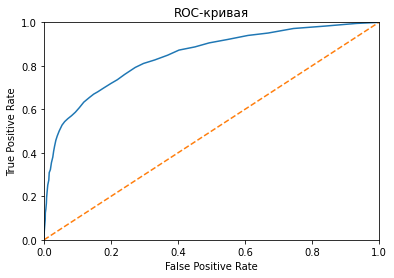

In [23]:
probabilities_valid = model.predict_proba(features_valid)#вычислим вероятности
probabilities_one_valid = probabilities_valid[:, 1]#предскажем значения первого класса

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)# перберм пороги и вернем три списка
auc_roc = roc_auc_score(target_valid, model.predict_proba(features_valid)[:,1])#посчитаем площадь под кривой
print("Площадь под ROC-кривой AUC-ROC:", auc_roc)#выведим значение метрики

plt.figure()

plt.plot(fpr, tpr)# построим график

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])# < применим функции plt.xlim() и plt.ylim(), чтобы
plt.ylim([0.0, 1.0])#   установить границы осей от 0 до 1 >

plt.xlabel('False Positive Rate')# примените функции plt.xlabel() и plt.ylabel(), чтобы
plt.ylabel('True Positive Rate')# подписать оси "False Positive Rate" и "True Positive Rate" 

plt.title('ROC-кривая')# добавим к графику заголовок "ROC-кривая" функцией plt.title()

plt.show()

___Комментарии:___ Соотношение TPR(полнота-доля верно предсказанных объектов к общему числу объектов) к FPR(доля ложных срабатываний к общему числу объектов за пределами класса). Доля TPR выше, так как мы видим графие выше, значит и качество модели лучше. Метрика AUC-ROC 0,84, но далеко до идеальной 1.

## Тестирование модели

#### Поиск по сетке

In [24]:
best_score = 0
for gamma in [100, 300, 1, 500]:
    for c in [100, 300, 1, 500]:
        # Проведем обучение для каждой возможной комбинации параметров
        svm = SVC(gamma=gamma,C=c)
        svm.fit(features_train, target_train)
        score = svm.score(features_valid,target_valid)
        # Найдем наиболее эффективные параметры
        if score > best_score:
            best_score = score
            best_parameters = {'gamma':gamma,"C":c}
#Используем лучшие параметры для построения новой модели
svm = SVC(**best_parameters)

#Обучим модель
svm.fit(features_train, target_train)

#Оценка модели
test_score = svm.score(features_test,target_test)

print('Best score:{:.2f}'.format(best_score))
print('Best parameters:{}'.format(best_parameters))
print('Best score on test set:{:.2f}'.format(test_score))

#Прогноз результатов теста
features_test_lab = svm.predict(features_test)
print(len(target_test))

Best score:0.81
Best parameters:{'gamma': 1, 'C': 1}
Best score on test set:0.82
1200


___Комментарии:___ Мы получили низкий гамма-параметр - 1, что означает что у нас больше точек группируется вместе, т.е. много точек принадлежашие к одному классу, об этом и говорит парметр С равный 1. Наилучшую точность нам дал параметр best score - 82% правильных ответов с наилучшими гиперпараметрами в диапазоне от 1 до 500.

#### Значение метрики F1 на тестовой выборке при увелечении выборки

In [25]:
predicted_test = model.predict(features_test)#предскажем модель

print("F1 на тестовой выборке:", f1_score(target_test, predicted_test))#посчитаем метрику f1

F1 на тестовой выборке: 0.5972850678733032


#### Значение ROC-кривой на тестовой выборке

In [26]:
probabilities_test = model.predict_proba(features_test)#вычислим вероятности
probabilities_one_test = probabilities_test[:, 1]#предскажем значения первого класса

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)# перберм пороги и вернем три списка
auc_roc = roc_auc_score(target_test, model.predict_proba(features_test)[:,1])#посчитаем площадь под кривой
print("Площадь под ROC-кривой AUC-ROC:", auc_roc)#выведим значение метрики

Площадь под ROC-кривой AUC-ROC: 0.8531170690719527


___Комментарии:___ ROC предназначен для многих различных уровней пороговых значений и, следовательно, имеет много значений F. Оценка F1 применима к любой конкретной точке кривой ROC. Чтобы метрика F1 которая равна на тестовой выборке 60% была выше, нужно чтобы точность и полнота были выше. ROC усредняет по всем возможным пороговым значениям нашу метрику F. Площадь ROC 85%.

## Выводы

Для того, чтобы спрогнозировать, уйдет ли клиент из банка в ближайшее время или нет, мы изучили исторические данные и построили лучшую модель для прогноза поведения клиента в случае расторжения договоров с банком. В датасете мы заполнили пропуски в некотором столбце, анализировали признаки, в том числе целевой признак Exited, построили матрицу зависимости от целевого признака. В ходе исследоввания задачи мы масштабировали признаки, затем разделили датасет на валидационную, обучающую и тестовую выборки. Выбрали наилучшую модель случайного леса, доля правильных ответов составили 86%. Мы проверили адекватность модели, в резултате модель проверку не прошла. Следовательно, мы изчили матрицу ошибок. F1 метрика на валидационной выборке составила 58%. Чтобы поднять метрику, мы увеличили выборку и метрика немного поднялась 60%. Мы изменили порог, но это не дало кспеха. Далее мы построили ROC-кривую, котрая составила 84%. На тестовой выборке мы искали лучшие гиперпараметры и получили 82% правильных ответов по сетке. Значения F1 на тестовой выборке составила 60%, AUC-ROC 85%, значит модель применена успешно.